In [1]:
import os
import umap
import torch
import ncvis
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from scipy import stats
from weblogolib import *
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from matplotlib import rcParams
from IPython.display import Image
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

In [2]:
from matplotlib import cm
from sklearn.decomposition import PCA

# Figure 4

In [3]:
np.random.seed(1341)
torch.manual_seed(1341)

In [4]:
encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
model = DKL(encoder, [1,5*32]).cuda()
model.load_state_dict(torch.load("../models/DeepHF/WT/CNN59.ptch"))
model = model.eval()

In [5]:
transformer = get_Cas9_transformer(True)

In [6]:
GENE_TABLE = "../results/Chr22/DeepHF/WT/chr22_grnas/LOC440792.tsv"

In [7]:
current_df = pd.read_csv(GENE_TABLE, sep="\t", header=None).dropna()
current_df = current_df[current_df[3].apply(lambda x: len(x) == 23)]
tds = DeepHFDataset(
    current_df, np.arange(current_df.shape[0]), transformer, sequence_column=3, 
    label_column=5
)
tld = DataLoader(tds, shuffle=False, batch_size=256)
tb_oa = []
tb_va = []
tb_ra = []
for transformed_batch, _ in tqdm(tld):
    tb_o = encoder(transformed_batch)[0].cpu().data.numpy()
    tb_ra.extend(tb_o)
    tb = model(transformed_batch)
    tb_o = model.likelihood(
        tb[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_v = model.likelihood(
        tb[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_oa.extend(tb_o)
    tb_va.extend(tb_v)

100%|██████████| 11/11 [00:01<00:00,  6.10it/s]


In [8]:
tb_ra = np.stack(tb_ra).reshape(-1, 5*32)

In [9]:
nvis_cm = ncvis.NCVis(random_seed=1341)
nv_cm = nvis_cm.fit_transform(tb_ra)

In [10]:
np.random.seed(12314)
ln = linkage(nv_cm, "average")

In [11]:
rcParams["figure.figsize"] = (8, 2)

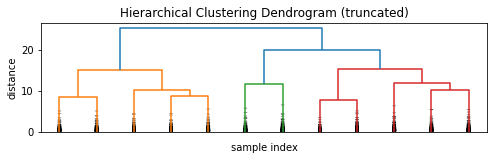

In [12]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    ln,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [13]:
max_d = 2
clusters = fcluster(ln, max_d, criterion='distance')

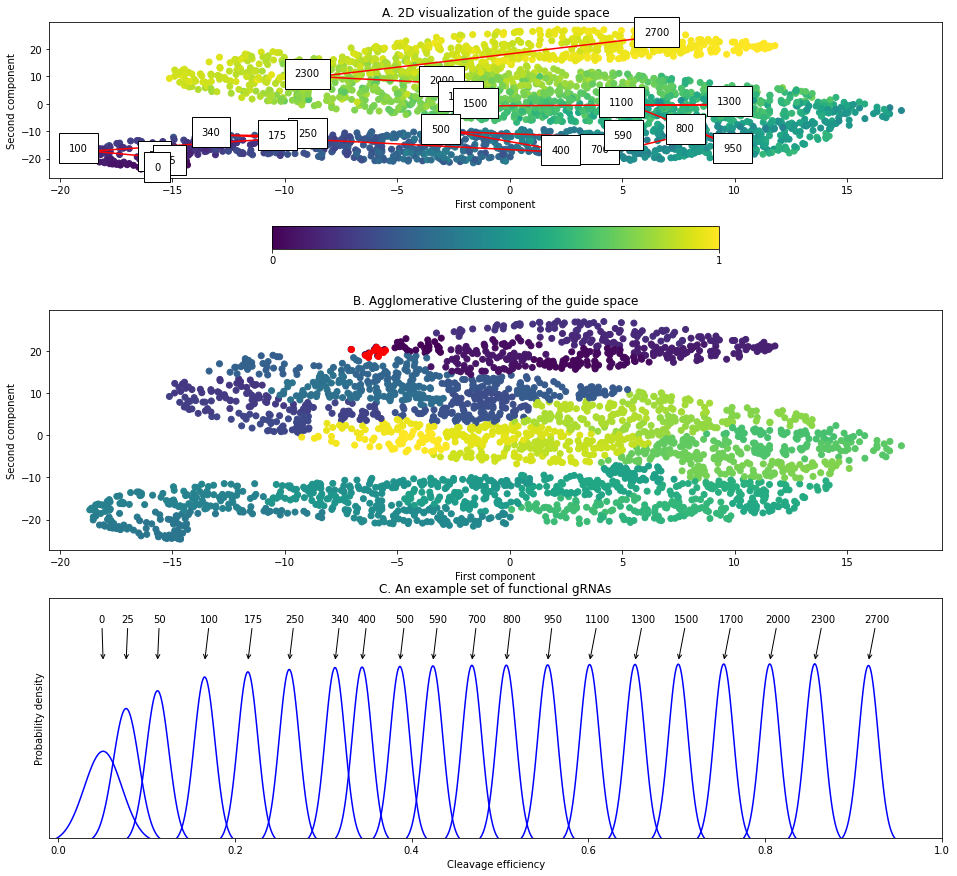

In [43]:
rcParams["figure.figsize"] = (16, 15)
numbers = [
    0, 25, 50, 100, 175, 250, 340, 400, 500, 590, 700, 800, 950,
    1100, 1300, 1500, 1700, 2000, 2300, 2700
]
tb_oa_o = np.array(sorted(tb_oa))
tb_va = np.array(tb_va)
mus = [tb_oa_o[a] for a in numbers]
sigmas = [tb_va[tb_oa == a] for a in mus]
Xs = [nv_cm.T[0][tb_oa == a] for a in mus]
Ys = [nv_cm.T[1][tb_oa == a] for a in mus]
top20 = np.arange(tb_oa_o.shape[0])[clusters == 1]
Xs_top20 = [nv_cm.T[0][a] for a in top20]
Ys_top20 = [nv_cm.T[1][a] for a in top20]
plt.subplot(3, 1, 1)
plt.colorbar(
    cm.ScalarMappable(), ticks=range(2), pad=0.2, spacing="proportional", orientation="horizontal",
    shrink=0.5
)
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=tb_oa)
plt.scatter(Xs, Ys, color="red", marker=".", alpha=0.2)
plt.plot(Xs, Ys, color="red")
plt.title("A. 2D visualization of the guide space")
for a,b,num in list(reversed(list(zip(Xs, Ys, numbers)))):
    plt.annotate(
        str(num), xy=(a-1,b), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
plt.xlabel("First component")
plt.ylabel("Second component")
plt.subplot(3,1,2)
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=clusters)
plt.scatter(Xs_top20, Ys_top20, color="red")
plt.title("B. Agglomerative Clustering of the guide space")
plt.xlabel("First component")
plt.ylabel("Second component")
plt.subplot(3,1,3)
for mu, sigma, num in zip(mus, sigmas, numbers):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color="blue")
    plt.annotate(
        str(num), xy=(mu,37), xytext=(mu-0.005, 45), 
        arrowprops=dict(facecolor='black', arrowstyle="->"),
    )
plt.xlim((-0.01,1))
plt.ylim((1,50))
plt.yticks([])
plt.xlabel("Cleavage efficiency")
plt.ylabel("Probability density")
plt.title("C. An example set of functional gRNAs")
plt.show()

In [15]:
with open("Figure4_cluster.fa", "w") as oh:
    for a in current_df.iloc[top20][3].values:
        oh.write(">\n"+a[:-2]+"\n")

In [16]:
fin = open("Figure4_cluster.fa")
seqs = read_seq_data(fin)
logodata = LogoData.from_seqs(seqs)
logooptions = LogoOptions()
logooptions.title = "Cluster Logo"
logoformat = LogoFormat(logodata, logooptions)
png = png_formatter(logodata, logoformat)
with open("Figure4_logo.png", "wb") as oh:
    oh.write(png)

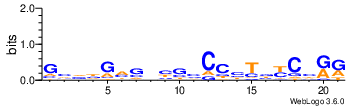

In [17]:
Image("Figure4_logo.png")

# Supplementary Table 4

In [18]:
ST4 = current_df[[3,4]]

In [19]:
ST4.columns = ["gRNA", "strand"]

In [20]:
clusters[numbers]

array([107,  59, 104,  18,  77,   4,  43, 138,  43, 136, 123,  79,  44,
        95, 147,  51,  11,  17,  95,  50], dtype=int32)

In [21]:
ST4["mean"] = tb_oa_o
ST4["std"] = tb_va
ST4["X"] = nv_cm.T[0]
ST4["Y"] = nv_cm.T[1]
ST4["cluster"] = clusters

<ipython-input-21-773227629831>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ST4["mean"] = tb_oa_o
<ipython-input-21-773227629831>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ST4["std"] = tb_va
<ipython-input-21-773227629831>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [22]:
ST4

,gRNA,strand,mean,std,X,Y,cluster
0,ACTTTGGGAGGTGAGGCTGGTGG,+,0.050980,0.010993,11.157615,-13.310658,107
1,AAAACATTAGCCAGGCATGGCGG,+,0.051311,0.011163,-8.357059,-13.899493,92
2,AGCACTTTGGGAGGTGAGGCTGG,+,0.051692,0.010969,7.118173,-3.315840,133
3,GCCTGTAATCCCAGCCACTCGGG,+,0.052197,0.011058,1.036014,-12.064982,102
4,GAGACAGAATTGCTTGAACCCGG,+,0.052318,0.010950,5.145182,1.497775,148
...,...,...,...,...,...,...,...
2778,CAAGCAGTCAGCCAGGTCCTGGG,-,0.929607,0.011095,-3.495202,-20.537832,82
2779,TTCTGAGGTGAGGCAGGAAAAGG,-,0.929669,0.010976,11.342340,-15.038298,107
2780,GCCTGGCTCTCACGTCTCAGGGG,-,0.929681,0.010937,-5.567986,20.389957,1
2781,CTTTCTTCGAATTCCAGTTTAGG,-,0.929728,0.012878,-14.850359,-20.383028,69


In [23]:
ST4.to_csv("SupplementaryTable4.csv")

# Supplementary File 1

In [24]:
def logo(n=1, folder="logos"):
    if not op.exists(folder):
        os.makedirs(folder)
    top20 = np.arange(tb_oa_o.shape[0])[clusters == n]
    with open("test.fa", "w") as oh:
        for a in current_df.iloc[top20][3].values:
            oh.write(">\n"+a[:-2]+"\n")
    fin = open("test.fa")
    seqs = read_seq_data(fin)
    logodata = LogoData.from_seqs(seqs)
    logooptions = LogoOptions()
    logooptions.title = "Most Active Cluster Logo"
    logoformat = LogoFormat(logodata, logooptions)
    png = png_formatter(logodata, logoformat)
    with open(op.join(folder, str(n)+".png"), "wb") as oh:
        oh.write(png)

In [25]:
for a in tqdm(np.arange(np.unique(clusters).shape[0])):
    logo(a+1)

100%|██████████| 174/174 [00:56<00:00,  3.09it/s]


In [26]:
out_md = "SupplementaryFile1.md"

In [27]:
fs = [op.join("logos", a) for a in sorted(
    [a for a in os.walk("logos")][0][2], 
    key=lambda x: int(x.split(".")[0])
)]

In [28]:
with open(out_md, "w") as oh:
    for a in fs:
        oh.write(op.split(a)[-1].split(".")[0]+"\n")
        oh.write("![]("+a+")\n")